In [1]:
%load_ext autotime
%matplotlib inline
%load_ext autoreload

In [2]:
import pandas as pd
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

time: 994 ms


Seven and a half is a card game that's something like 2/3rds blackjack and 1/3 poker. It's known as [setto e mezzo](https://en.wikipedia.org/wiki/Sette_e_mezzo) in Italy or Siete y Media in Spain (that literally just means 7.5 in Italian/Spanish, but the point being it is popular in these other countries) and is played with a deck of 40 cards (standard deck of cards, minus the 8s, 9s, and 10s). Players receive one card face down (as does the dealer), and a player's goal is to beat the dealer by getting a hand as close to 7 1/2  as possible without busting (going over 7.5). Face cards are worth 1/2 point and all other cards are worth their face value. A player can hit until they either choose to stay or they bust, at which point the dealer can then hit until they choose to stay or bust as well. Ties go to the dealer. When I have played this game, a player doesn't need to place their bet on their hand until receiving their first card, though I understand this may not be traditional. 

After playing the game a few times, I've started to get curious on what ideal gameplay actually looks like. Since this isn't a game of perfect information (both the player and the dealer have one face-down card, so an element of bluffing - the poker aspect - is certainly at play), you can't necessarily solve for a true dominant strategy, but it's at least possible to map out what ***would*** be ideal gameplay if all information was known in each stage. Here's an attempt to do that (and a 'fun' opportunity to walk through a Monte Carlo simulation in Python).

To start things off - let's see what happens if your goal is just to maximize your hand, regardless of what any other player has. We'll use a basic "hit until you reach a score of X" strategy, change what X is, and see what X gives you the highest expected value if we simulate 1,000,000 hands for each X:

In [3]:
random.seed(123)
overall_scores = []
for i in range(15):
    threshold = (0.5 + i * 0.5)
    final_scores = []
    for j in range(1000000):
        hand = []
        deck = [2, 3, 4, 5, 6, 7, 1, 0.5, 0.5, 0.5] * 4
        random.shuffle(deck)
        hand.append(deck.pop())
        score = sum(hand)
        while score < threshold:
            hand.append(deck.pop())
            score = sum(hand)
        if score > 7.5:
            final_score = 0
        else:
            final_score = score
        final_scores.append(final_score)
    overall_scores.append([threshold, final_scores])
    
score_data = pd.DataFrame(dict(overall_scores))
score_data.mean()

0.5    2.952205
1.0    3.855234
1.5    4.260065
2.0    4.445243
2.5    4.620090
3.0    4.710584
3.5    4.741632
4.0    4.741801
4.5    4.589865
5.0    4.466452
5.5    4.062339
6.0    3.765453
6.5    3.025663
7.0    2.469758
7.5    1.282080
dtype: float64

time: 4min 13s


Alright, so the highest expected value is "hit until your hand is at least 3.5 / 4ish" which seems pretty reasonable, considering it's about the halfway point (reasonably high, but not so high that you'll bust very frequently). 

Now let's work backwards a little. Assume you're the dealer, and you know a player has X. Your goal is to at least tie X, which means your strategy is simply to keep hitting until your score is at least X. If you bust before you hit X, you lose. If you don't, you win. What're your odds of winning? 

In [4]:
random.seed(123)
overall_scores = []
for i in range(15):
    threshold = (0.5 + i * 0.5)
    final_scores = []
    for j in range(1000000):
        hand = []
        deck = [2, 3, 4, 5, 6, 7, 1, 0.5, 0.5, 0.5] * 4
        random.shuffle(deck)
        hand.append(deck.pop())
        score = sum(hand)
        while score < threshold:
            hand.append(deck.pop())
            score = sum(hand)
        if score > 7.5:
            final_score = 0
        else:
            final_score = 1
        final_scores.append(final_score)
    overall_scores.append([threshold, final_scores])
    
dealer_wins = pd.DataFrame(dict(overall_scores))
dealer_wins.mean()

0.5    1.000000
1.0    1.000000
1.5    0.980636
2.0    0.971922
2.5    0.942629
3.0    0.925669
3.5    0.877645
4.0    0.847556
4.5    0.777102
5.0    0.732099
5.5    0.633591
6.0    0.569280
6.5    0.436852
7.0    0.345966
7.5    0.170944
dtype: float64

time: 4min 7s


Text(0.5, 1.0, '')

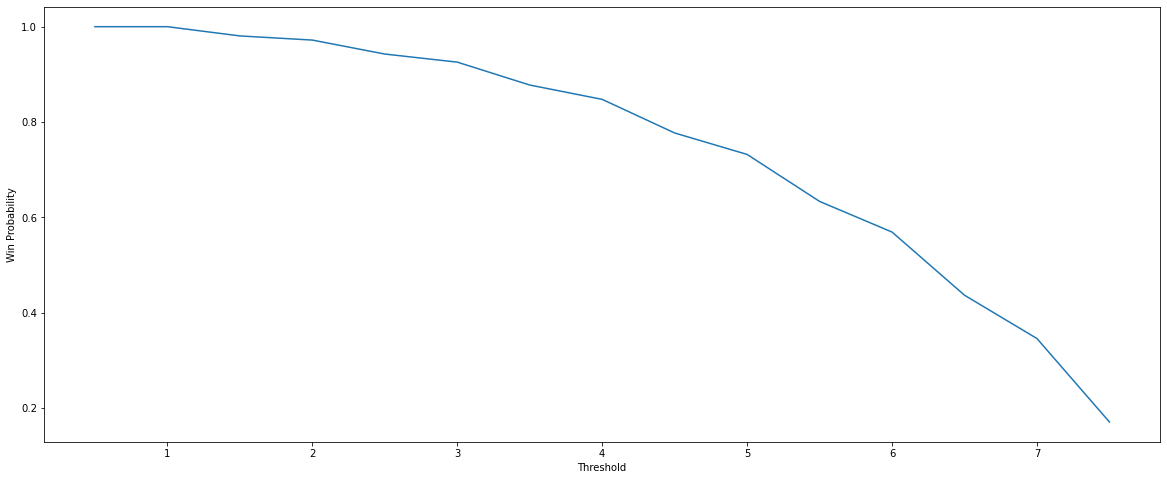

time: 309 ms


In [5]:
test = pd.DataFrame(dealer_wins.mean()).reset_index()
test.columns = ['Threshold', 'Win Probability']
plt.figure(figsize=(20,8))
sns.lineplot(data = test, 
             x = 'Threshold',
             y = 'Win Probability').set_title('')

You'll note that the Python code to run this analysis barely changed - I only needed to adjust to show me a binary 1 / 0 (did we beat X or not), rather than the mean score from the X strategy.  

Results seem pretty straightforward - the dealer's odds of winning decrease as the score he has to beat goes up - and the odds are falling a bit less than linearly as we go - but it's actually pretty interesting to me to see how favored the dealer is in this game. Based on this, the dealer is favored to win for any player score under 6.5, which I think suggests a couple things: 

- First, it pays to be aggressive - even if score-maximizing in the abstract happens with a cutoff of 3.5 /4 or so, you're probably going to lose as the player unless you keep hitting.
- Second, bluffing clearly matters. 

Okay, now let's take a step back and think about this from the player's perspective. Every time you decide whether to hit, you impact the probability that you win the game in one of two ways:
- You bust with some probability (call this y), which results in a 100% chance the dealer wins
- Conditional upon not busting, you lower the dealer's chances of winning by some probability (call this z)

For example, say you start with an Ace, so you hand is worth 1. The table above shows a dealer with perfect information has a 100% chance of winning here. If you draw a 7, you bust, so your odds don't get any worse - you still lose. If you draw a 6, your hand is now worth 7, so the dealer has a 35% chance of winning - your odds of winning have improved by 65 percentage points. 

As a player, your goal is to maximize the probability you have of winning the game. Phrased differently, your goal is to minimize the probability the dealer has of winning the game. As such, a player should hit only when doing so increases their chances of winning (and decreases the dealer's chances). Since we know the probability the dealer has of winning given every player score, we can figure out exactly how a hit is expected to impact your probability of winning, which tells us when we should / should not hit. 

Given that, here's what we'll do: 
- Take the inverse of 'dealer win probability' as 'player win probability' 
- Start at each possible score (0.5 to 7.5), and simulate 1,000,000 hands where you take a hit. 
- Compare starting win probability to average ending win probability to see where a hit improves your win probability. 

In [6]:
player_win_prob = (1 - dealer_wins.mean())

time: 29.5 ms


In [7]:
random.seed(123)

player_outcomes = []
for i in range(15):
    start = (0.5 + i * 0.5)
    final_scores = []
    start_probs = []
    end_probs = []
    bust_count = []
    for j in range(10000):
        hand = [start]
        start_win_probability = player_win_prob[start]
        deck = [2, 3, 4, 5, 6, 7, 1, 0.5, 0.5, 0.5] * 4
        random.shuffle(deck)
        hand.append(deck.pop())
        final_score = sum(hand)
        try: 
            end_win_probability = player_win_prob[final_score]
        except:
            end_win_probability = 0
            
        if final_score > 7.5:
            bust = 1
        else:
            bust = 0
        
        start_probs.append(start_win_probability)
        end_probs.append(end_win_probability)
        final_scores.append(final_score)
        bust_count.append(bust)
        
    player_outcomes.append([start, statistics.mean(bust_count), statistics.mean(final_scores), statistics.mean(start_probs), statistics.mean(end_probs)])
    
player_wins = pd.DataFrame((player_outcomes))
player_wins.columns = ['score_start', 'bust_prob', 'score_end_avg', 'win_prob_start', 'win_prob_end']
player_wins['score_increase'] = player_wins['score_end_avg'] - player_wins['score_start']
player_wins['prob_change'] = player_wins['win_prob_end'] - player_wins['win_prob_start']

player_wins

,score_start,bust_prob,score_end_avg,win_prob_start,win_prob_end,score_increase,prob_change
0,0.5,0.0000,3.43460,0.000000,0.215628,2.93460,0.215628
1,1.0,0.1011,3.94575,0.000000,0.164628,2.94575,0.164628
2,1.5,0.1030,4.45290,0.019364,0.222662,2.95290,0.203298
3,2.0,0.2055,4.99180,0.028078,0.176448,2.99180,0.148370
4,2.5,0.1959,5.43205,0.057371,0.234194,2.93205,0.176823
5,3.0,0.2993,5.93720,0.074331,0.185775,2.93720,0.111444
6,3.5,0.3006,6.47120,0.122355,0.246702,2.97120,0.124347
7,4.0,0.3959,6.94845,0.152444,0.205362,2.94845,0.052918
8,4.5,0.4024,7.45975,0.222898,0.254988,2.95975,0.032090
9,5.0,0.4999,7.93755,0.267901,0.218546,2.93755,-0.049355


time: 7.4 s


Pretty straightforward! Looks like the player should hit if their hand is anything below 5 - above there, hitting has negative value (the odds of busting out are too great). 

Astute cardplayers will notice that the above is a *bit* simplistic - I'm pretending the entire deck of cards is in play when you take a hit, when in reality at least one (or two) cards have to have been played already to make the player's starting hand. That's totally fair, but: 
- I think the actual analysis there is beyond the scope of what I can put together,
- For someone not counting cards, in practice you won't really be able to adjust your math on the fly sufficiently to use a more sophisticated version, and 
- In theory, if someone were playing with an infinite number of decks, the math above is still right, so let's go with it. 

Now - last step. Given the above, we know the dealer's odds of winning a hand based on where the player ends up, and we know how the player should act given those odds (hit until 5 or higher, then stay). My last question is how the player's odds of winning vary based on the card they're dealt. Intuitively, I'd expect 6s and 7s to be great cards (clearly if you get a 7 off the bat, you've got nearly a 2/3rds chance of winning, which is great), but I'm not sure whether a face card (0.5) or an Ace (1) will be a lot better than a 3 or a 4 - your starting score is lower, but your odds of busting are a lot better. Let's give it a shot:  

In [8]:
random.seed(123)
overall_outcomes = []

for i in range(1000000):
    player_hand = []
    dealer_hand = []
    deck = [2, 3, 4, 5, 6, 7, 1, 0.5, 0.5, 0.5] * 4
    random.shuffle(deck)
    player_hand.append(deck.pop())
    player_first_card = player_hand[0]
    dealer_hand.append(deck.pop())
    player_score = sum(player_hand)
    dealer_score = sum(dealer_hand)
    while player_score < 5:
        player_hand.append(deck.pop())
        player_score = sum(player_hand)
    if player_score > 7.5:
        player_final_score = 0
    else:
        player_final_score = player_score
    while dealer_score < player_final_score:
        dealer_hand.append(deck.pop())
        dealer_score = sum(dealer_hand)
    if dealer_score > 7.5:
        dealer_final_score = 0
    else:
        dealer_final_score = dealer_score
    if dealer_final_score >= player_final_score:
        outcome = 0
    else:
        outcome = 1
    overall_outcomes.append([player_first_card, outcome])

time: 16.9 s


In [9]:
result = pd.DataFrame(overall_outcomes, columns = ['first_card', 'outcome'])
summary = result.groupby('first_card').agg(['mean', 'count']).reset_index()
summary.columns = ['First Card', 'Win Probability', 'Count']
summary

,First Card,Win Probability,Count
0,0.5,0.386347,299485
1,1.0,0.306151,99944
2,2.0,0.267725,99931
3,3.0,0.219691,99977
4,4.0,0.216987,100453
5,5.0,0.275738,100222
6,6.0,0.435418,100113
7,7.0,0.665212,99875


time: 472 ms


Not surprisingly, 7 was confirmed best (about a 2:1 favorite to win) - but the rest is pretty interesting. After 6, the next best starting card is actually 0.5 by a pretty wide margin - it's almost twice as good as starting with a 3 or a 4, and isn't much worse than a 6 (39% chance to win versus 44%). The player's overall odds of winning a hand here are ~35%. 

So, to recap: 
- In the abstract, hitting until 3.5 or 4 gets you the highest average hand
- Since the dealer goes second, and this analysis assumes he knows what he has to get, hitting until 5 is the best strategy
- The player is a pretty big underdog here, with ~35% chance of winning in a perfect information setting. Unless they're dealt a 7, the dealer is favored, and that doesn't change unless they've got at least 6.5 in their hand. 
- Given the above, it's obvious how important the lack of perfect information is in this game - bluffing is huge for the player. In terms of optimal betting strategy you should bet big if and only if you get a 7, unless you're trying to bluff. Conversely, if you're the dealer, you're not really afraid of a player betting big unless you're pretty sure they have a 7 - anything else and you're favored to win the hand. 

All in all, this was a pretty fun and illuminating exercise - and I feel a bit better about how to approach the game going forward. 